In [2]:
import torch
import torch.nn as nn
import numpy as np
import time
from function import fun1,fun2,fun3,fun4,fun5,fun6,fun7
from my_NN import *
import os
import matplotlib.pyplot as plt
import ycx_para_config as ycx

boundary_loss_list=[]
consist_loss_list=[]

# 确保 model 文件夹存在
os.makedirs('./model_parameter', exist_ok=True)

debug=False
debug2=False

use_multi_path_boundary_loss=ycx.use_multi_path

loss_list_final=[]

In [3]:
def sample_t_per_interval_and_generate_f_start(dtype,device,seg_step=16,batch_size=32,f_start_min=0.1,f_start_max=0.9):
    t_seg=torch.linspace(0,1,seg_step+1,dtype=dtype,device=device)
    t_seg=t_seg.repeat(batch_size,1)
    
    rand_move=torch.empty((batch_size,seg_step+1),dtype=dtype,device=device).uniform_(-ycx.random_amplititude/seg_step,ycx.random_amplititude/seg_step)
    rand_move[:,0]=0
    rand_move[:,-1]=0
    
    t_seg+=rand_move
    f_start_rand=torch.empty((batch_size,1),dtype=dtype,device=device).uniform_(f_start_min,f_start_max)
    
    return t_seg , f_start_rand


In [4]:
def boundary_loss_calculator(model,t_seg,f_start_rand,seg_step,loss_func,batch_size,boundary_func=fun1,f_start_min=0.1,f_start_max=0.9):
    #注意这里t_seg还是size为(batch_size,seg_step+1)的tensor
    t_seg_copy=t_seg.clone()
    t_seg_copy=t_seg_copy.unsqueeze_(-1)
    temp_loss_list=[]
    
    log_step=int(np.log2(seg_step))
    
    delta=t_seg_copy[:,1:]-t_seg_copy[:,:-1]
    func_f_end_value=boundary_func(f_start_rand)
    
    model_f_end_value=f_start_rand
    for i in range(seg_step):
        model_f_end_value=model_f_end_value + delta[:,i] * model.forward(model_f_end_value,t_seg_copy[:,i],delta[:,i])
        
    boundary_loss=loss_func(model_f_end_value,func_f_end_value)
    temp_loss_list.append(boundary_loss.item())  

    if debug:
        print('\nboundary_loss max step:',boundary_loss.item())  
    ##############################
    if use_multi_path_boundary_loss:
        temp_step=seg_step
        if debug:print('log_step:',log_step)
        for i in range(log_step):
            t_seg_copy=t_seg_copy[:,::2]
            temp_step=temp_step//2
            delta=t_seg_copy[:,1:]-t_seg_copy[:,:-1]
            model_f_end_value=f_start_rand
            for j in range(temp_step):
                model_f_end_value=model_f_end_value + delta[:,j] * model.forward(model_f_end_value,t_seg_copy[:,j],delta[:,j])
            if debug:print(f'step_boundary_loss steplen {2**(i+1)}:',loss_func(model_f_end_value,func_f_end_value).item())
            
            temp_loss_list.append(loss_func(model_f_end_value,func_f_end_value).item())
            
            boundary_loss+=loss_func(model_f_end_value,func_f_end_value)
            
        loss_list_final.append(temp_loss_list)
        if debug:print('boundary_loss:',boundary_loss.item())
    return boundary_loss
    

In [5]:
def consist_loss_calculator(model,t_seg,seg_step,loss_func,batch_size,boundary_func,f_start_min,f_start_max,consist_depth):
    t_seg_copy=t_seg.clone()
    dtype=t_seg.dtype
    device=t_seg.device
    consist_loss=0
    for i in range(consist_depth):
        
        mid_point=(t_seg_copy[:,1:]+t_seg_copy[:,:-1])/2
        #这里构建下一个深度的t_seg_copy
        temp_result=torch.empty((batch_size,t_seg_copy.shape[1]*2-1),dtype=t_seg.dtype,device=t_seg.device)
        #不知道torch.empty的多次使用会不会导致内存消耗过大?
        temp_result[:,::2]=t_seg_copy
        temp_result[:,1::2]=mid_point
        del t_seg_copy
        t_seg_copy=temp_result
        del temp_result
    len_t=t_seg_copy.shape[1]-1
    max_step_len=len_t//2**3
    t_seg_copy=t_seg_copy.unsqueeze(-1)
    
    for t in range(1,max_step_len+1):
        end_num=len_t-2*t
        if end_num<0:
            break
        #generate the f_0 value
        f_start_rand=torch.empty((batch_size,end_num+1),dtype=dtype,device=device).uniform_(f_start_min,f_start_max)
        f_start_rand=f_start_rand.unsqueeze(-1)
        #calculate the one step loss
        delta=t_seg_copy[:,2*t:]-t_seg_copy[:,:end_num+1]
        one_step_result=f_start_rand+delta*model.forward(f_start_rand,t_seg_copy[:,:end_num+1],delta)
        
        #calculate the two step loss
        delta_1=t_seg_copy[:,t:end_num+1+t]-t_seg_copy[:,:end_num+1]
        delta_2=t_seg_copy[:,2*t:]-t_seg_copy[:,t:end_num+1+t]
        two_step_result_one=f_start_rand+delta_1*model.forward(f_start_rand,t_seg_copy[:,:end_num+1],delta_1)
        two_step_result_two=two_step_result_one+delta_2*model.forward(two_step_result_one,t_seg_copy[:,t:end_num+1+t],delta_2)
          
        norm_factors=delta**2
        
        consist_loss+=loss_func(two_step_result_two/norm_factors,one_step_result/norm_factors)
    
    return consist_loss
        

In [6]:
# epoch: 0
# batch_now: 0
# temp_consist_loss: 0.0009059240692295134
# len of t: 2597   mean loss of t: 3.488348360529509e-07
# temp_consist_loss: 0.0018372944323346019
# len of t: 4305   mean loss of t: 4.267815173831828e-07
# boundary_loss: 0.32094502449035645
# batch_now: 1
# temp_consist_loss: 0.0008293017162941396
# len of t: 2597   mean loss of t: 3.1933065702508265e-07
# temp_consist_loss: 0.0017165077151730657
# len of t: 4305   mean loss of t: 3.9872420793799436e-07
# boundary_loss: 0.09053190797567368
# batch_now: 2
# temp_consist_loss: 0.00021138165902812034
# len of t: 2597   mean loss of t: 8.139455488183301e-08
# temp_consist_loss: 0.00042922719148918986
# len of t: 4305   mean loss of t: 9.970434180933562e-08
# boundary_loss: 0.04014014080166817
# batch_now: 3
# temp_consist_loss: 0.00039545667823404074
# len of t: 2597   mean loss of t: 1.5227442365577233e-07
# temp_consist_loss: 0.0007676100940443575
# len of t: 4305   mean loss of t: 1.7830664205443845e-07
# boundary_loss: 0.08269376307725906
# batch_now: 4
# temp_consist_loss: 0.00044476924813352525
# len of t: 2597   mean loss of t: 1.712627062508761e-07
# temp_consist_loss: 0.0008746284293010831
# len of t: 4305   mean loss of t: 2.0316572109200536e-07
# boundary_loss: 0.06355836987495422

In [7]:
def get_loss(model,loss_func,batch_size,seg_step,dtype,device,boundary_func=fun1,f_start_min=0.1,f_start_max=0.6,consist_depth=5):
    use_consist_loss=False
    
    t_seg,f_start_rand=sample_t_per_interval_and_generate_f_start(dtype=dtype,device=device,seg_step=seg_step,batch_size=batch_size,f_start_min=f_start_min,f_start_max=f_start_max)
    
    boundary_loss=boundary_loss_calculator(model,t_seg,f_start_rand,seg_step,loss_func,batch_size,boundary_func=boundary_func,f_start_min=f_start_min,f_start_max=f_start_max)
    
    consist_loss=consist_loss_calculator(model,t_seg,seg_step,loss_func,batch_size,boundary_func,f_start_min,f_start_max,consist_depth=consist_depth)
    if debug2:
        print('boundary_loss:',boundary_loss.item())
        print('consist_loss:',consist_loss.item())
        
    boundary_loss_list.append(boundary_loss.item())
    consist_loss_list.append(consist_loss.item())
    
    loss=boundary_loss+consist_loss
    
    return loss
    

In [8]:
def iteration(model,optimizer,loss_func,device,dtype,batch_size,consist_depth=5,boundary_func=fun1):
    #train_loop
    optimizer.zero_grad()
    #计算loss
    #这里可以调节seg_step，f_start_min,f_start_max
    loss=get_loss(model,loss_func,batch_size,seg_step=ycx.choose_seg_step,dtype=dtype,device=device,boundary_func=boundary_func,consist_depth=consist_depth,f_start_min=ycx.f_start_min,f_start_max=ycx.f_start_max)
    #反向传播
    loss.backward()
    #更新参数
    optimizer.step()
    return loss.item()

In [9]:
def training(model,device='cuda',dtype=torch.float32,
          epoch=100,batch_size=32,lr=0.01,consist_depth=5,
          use_lr_scheduler=False,boundary_func=fun1):
    loss_list = []
    
    loss_func = nn.MSELoss()
    model.train()
    optimizer = torch.optim.Adam(params=model.parameters(),
                                 lr=lr,
                                 **({"fused": True} if "cuda" in str(device) else {}))#这里的fused=True，是为了使用apex加速

    # Use ReduceLROnPlateau as the learning rate scheduler
    if use_lr_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                               patience=ycx.lr_schedule_patience,
                                                               threshold=1e-4,
                                                               cooldown=ycx.lr_schedule_cooldown)
    
    init_time = time.time()
    for i in range(epoch):
        for _ in range(ycx.iteration_num):
            loss_term=iteration(model,optimizer,loss_func,device,dtype,batch_size,consist_depth=consist_depth,boundary_func=boundary_func)
            #设计中，iteration中已经完成反向传播，所以这里不需要再进行反向传播
            loss_list.append(loss_term)
        if (i+1)%20==0:
            print(f'epoch:{i+1},loss:{loss_term},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
        if (i+1)%50==0:
            torch.save(model.state_dict(),ycx.consist_para_file_name)
        if use_lr_scheduler:
            scheduler.step(loss_term)
        if optimizer.param_groups[0]["lr"] <= 1.1e-8:
            break
    print('terminal epoch: ',i+1)
    torch.save(model.state_dict(),ycx.consist_para_file_name)
    
    if debug==False:
        plt.plot(loss_list,label='loss')
        plt.legend()
    pass

now using cuda !
epoch:20,loss:0.0002653087140060961,time:6.85283088684082,lr:0.01
epoch:40,loss:0.00021861924324184656,time:13.198977947235107,lr:0.01
epoch:60,loss:0.0001943027600646019,time:19.62877130508423,lr:0.01
epoch:80,loss:0.00015997258014976978,time:26.073973178863525,lr:0.001
epoch:100,loss:0.00015719632210675627,time:32.387365102767944,lr:0.001
epoch:120,loss:0.00015661872748751193,time:38.70851540565491,lr:0.001
epoch:140,loss:0.00015448166232090443,time:44.779054403305054,lr:0.0001
epoch:160,loss:0.00015782899572513998,time:50.914090633392334,lr:0.0001
epoch:180,loss:0.00015616853488609195,time:56.72711253166199,lr:1e-05
epoch:200,loss:0.00015608608373440802,time:62.49605894088745,lr:1e-05
epoch:220,loss:0.0001515214826213196,time:68.4648826122284,lr:1.0000000000000002e-06
epoch:240,loss:0.00015423716104123741,time:75.02283883094788,lr:1.0000000000000002e-07
epoch:260,loss:0.00015405754675157368,time:80.8152904510498,lr:1.0000000000000002e-07
terminal epoch:  260
program

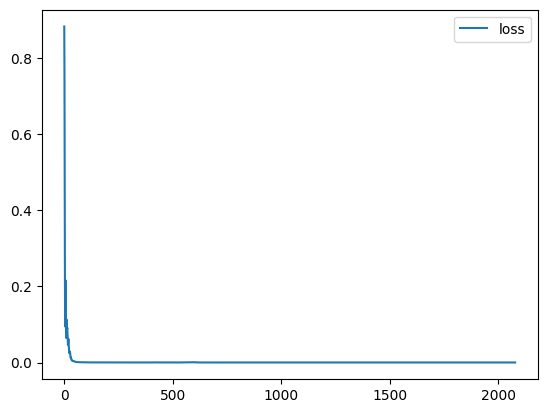

In [10]:
if __name__=='__main__':
    initial_time=time.time()
    if torch.cuda.is_available():
        device='cuda'
        print('now using cuda !')
    else:
        device='cpu'
        print('now using cpu !')
    dtype=torch.float32
    model=ycx.NN().to(device=device,dtype=dtype)
    #初始化网络参数
    from torch.nn import init
    for name, param in model.named_parameters():
        if 'weight' in name:
            init.normal_(param, mean=0, std=0.1)
        elif 'bias' in name:
            init.constant_(param, val=0)
            
    ############################################################
    #设置超参数
    batch_size=ycx.batch
    epoch=ycx.epoch
    if debug:epoch=ycx.debug_epoch
    consist_depth=3
    #training part 
    training(model,device,dtype,epoch=epoch,lr=ycx.lr,batch_size=batch_size,consist_depth=consist_depth,use_lr_scheduler=ycx.use_lr_schedule,boundary_func=ycx.choose_fun)
    
    print('program ended here \n terminal time: ', time.time()-initial_time)
    print('save model parameter in file name :',f' batch{batch_size}_epoch{epoch}.pth')

In [11]:
if use_multi_path_boundary_loss:
    list_length=len(loss_list_final)
    x=np.array([i for i in range(list_length)])
    loss_list_final=np.array(loss_list_final)

    end=5000
    begin=0
    begin=max(0,begin)
    end=min(end,list_length)
    for i in range(loss_list_final.shape[1]): 
        plt.plot(x[begin:end],loss_list_final[begin:end,i],label=f'step_length {2**i}')
    plt.ylim(0,0.5)
    plt.legend()
    plt.show()

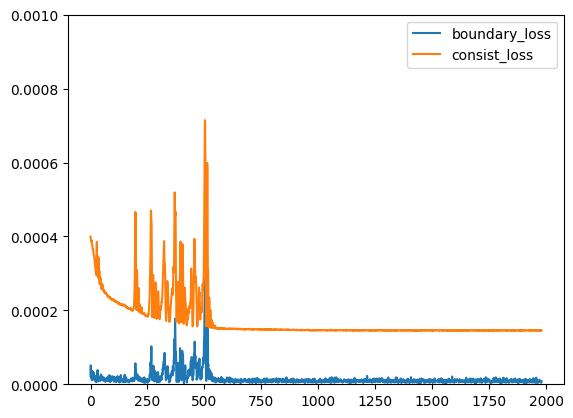

In [14]:
boundary_loss_list=np.array(boundary_loss_list)
consist_loss_list=np.array(consist_loss_list)

end=min(3500,len(boundary_loss_list))
begin=100

plt.plot(boundary_loss_list[begin:end],label='boundary_loss')
plt.plot(consist_loss_list[begin:end],label='consist_loss')
plt.ylim(0,0.001)
plt.legend()
plt.show()